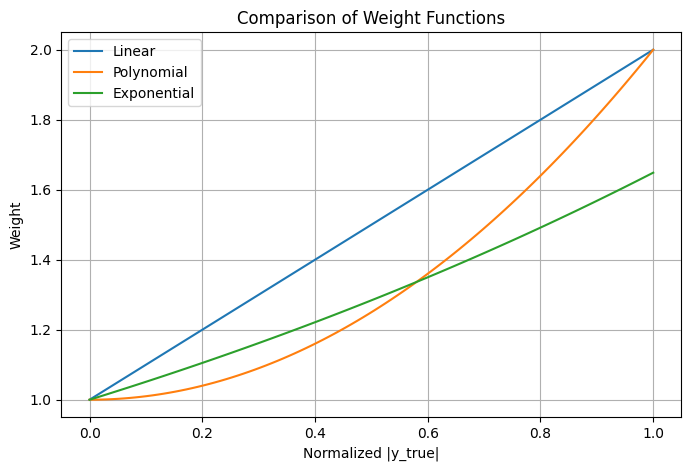

Training MSE model for Horizon 1
Horizon 1: RMSE (All) = 325.0945, RMSE (Extreme) = 681.2369
Training MSE model for Horizon 2
Horizon 2: RMSE (All) = 559.7209, RMSE (Extreme) = 1262.4174
Training MSE model for Horizon 3
Horizon 3: RMSE (All) = 678.2398, RMSE (Extreme) = 1536.4333
Training MSE model for Horizon 4
Horizon 4: RMSE (All) = 757.1314, RMSE (Extreme) = 1818.4930
Training MSE model for Horizon 5
Horizon 5: RMSE (All) = 736.9576, RMSE (Extreme) = 1582.2235
Training LINEAR model for Horizon 1
Horizon 1: RMSE (All) = 342.3741, RMSE (Extreme) = 754.9095
Training LINEAR model for Horizon 2
Horizon 2: RMSE (All) = 605.9527, RMSE (Extreme) = 1447.1217
Training LINEAR model for Horizon 3
Horizon 3: RMSE (All) = 678.1451, RMSE (Extreme) = 1507.5929
Training LINEAR model for Horizon 4
Horizon 4: RMSE (All) = 726.0464, RMSE (Extreme) = 1592.6226
Training LINEAR model for Horizon 5
Horizon 5: RMSE (All) = 751.8541, RMSE (Extreme) = 1709.1199
Training POLYNOMIAL model for Horizon 1
Horizon

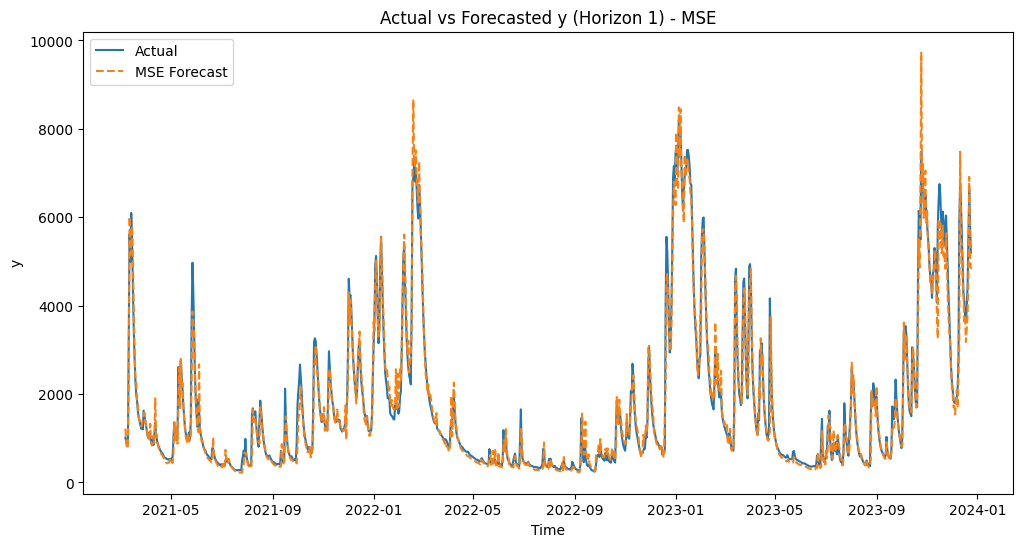

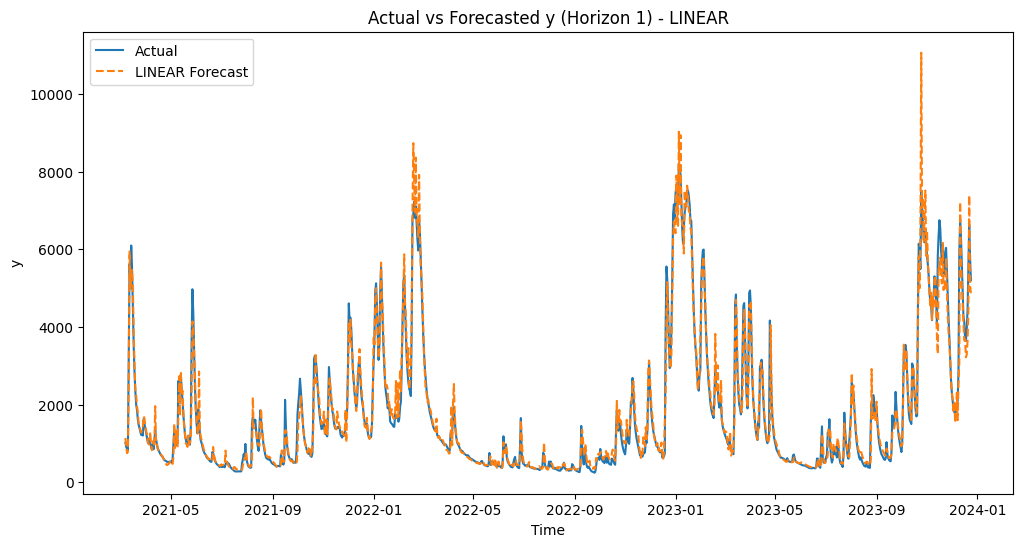

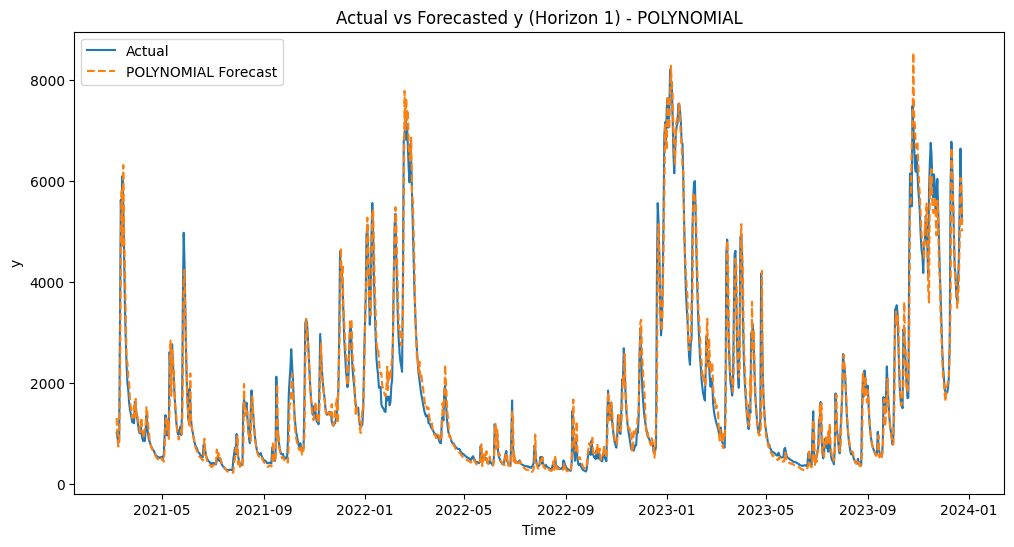

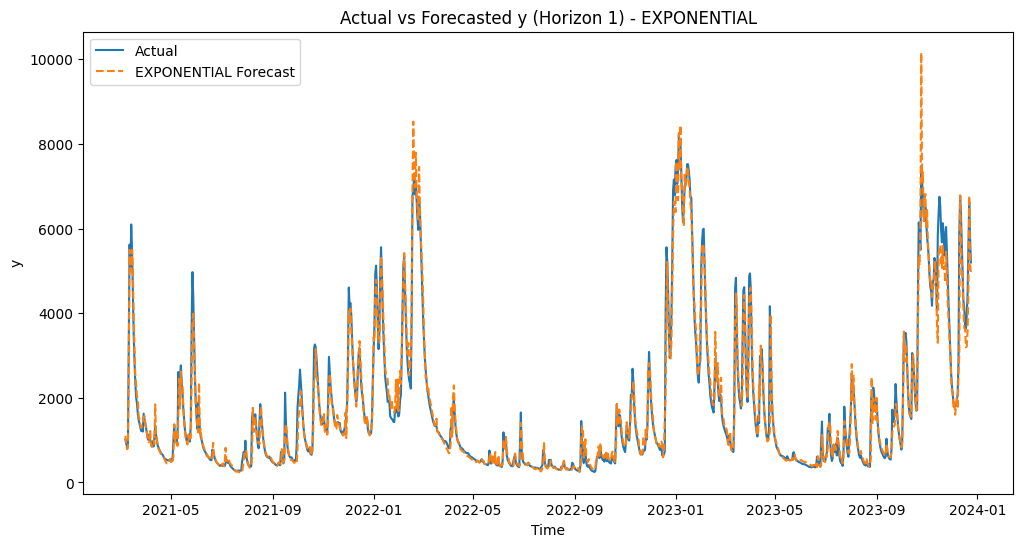

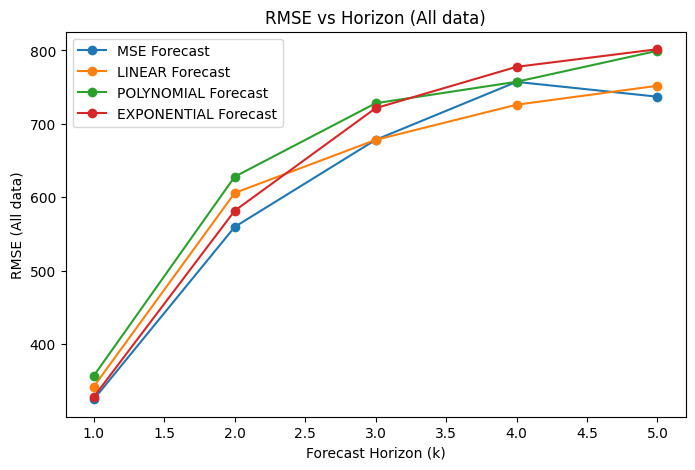

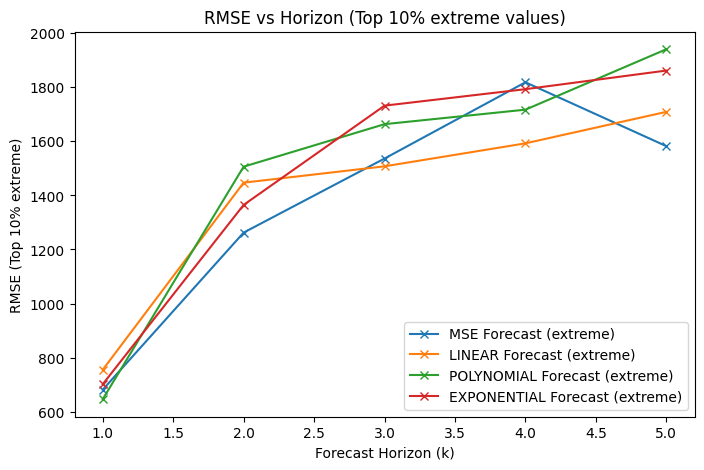

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

##########################################
# Data Loading and Preprocessing
##########################################

def low_pass(series, a1):
    return series.ewm(alpha=1 - a1, adjust=False).mean()

D = pd.read_csv("/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv")
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']
D_time_indexed = D.set_index('t').sort_index()

D_time_indexed.loc[D_time_indexed['temp_mean_daily'] > 35, 'temp_mean_daily'] = D_time_indexed['temp_mean_daily'].shift(1)
D_time_indexed.loc[D_time_indexed['precip_total_daily'] > 100, 'precip_total_daily'] = 0

D_time_indexed['temp_forecast'] = D_time_indexed['temp_mean_daily']
D_time_indexed['precip_forecast'] = low_pass(D_time_indexed['precip_total_daily'], a1=0.9)
D_time_indexed['Year_sin'] = np.sin(2 * np.pi * D_time_indexed.index.dayofyear / 365)
D_time_indexed['Year_cos'] = np.cos(2 * np.pi * D_time_indexed.index.dayofyear / 365)

score_period = D_time_indexed.index[-1023:]
score_start = score_period[0]

##########################################
# Helper Functions
##########################################

def create_offline_dataset_horizon(df, window_size, k, a1=0.9):
    X_hist_list, X_forecast_list, y_list, indices = [], [], [], []
    for i in range(window_size, len(df) - (k - 1)):
        target_date = df.index[i + (k - 1)]
        hist = df.iloc[i - window_size:i][['y', 'temp_mean_daily', 'precip_total_daily']].values.astype(np.float32)
        fcst = np.array([
            df.iloc[i + (k - 1)]['temp_forecast'],
            df.iloc[i + (k - 1)]['precip_forecast'],
            np.sin(2 * np.pi * target_date.dayofyear / 365),
            np.cos(2 * np.pi * target_date.dayofyear / 365)
        ], dtype=np.float32)
        label = float(df.iloc[i + (k - 1)]['y'])
        X_hist_list.append(hist)
        X_forecast_list.append(fcst)
        y_list.append(label)
        indices.append(target_date)
    return np.array(X_hist_list), np.array(X_forecast_list), np.array(y_list), np.array(indices)

def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Weighted MSE Loss Functions (Symmetric)
def weighted_mse_linear(y_true, y_pred):
    error = tf.square(y_true - y_pred)
    weights = 1.0 + (tf.abs(y_true) / tf.reduce_max(tf.abs(y_true)))
    return tf.reduce_mean(weights * error)

def weighted_mse_polynomial(y_true, y_pred):
    error = tf.square(y_true - y_pred)
    weights = 1.0 + (tf.abs(y_true) / tf.reduce_max(tf.abs(y_true)))**2
    return tf.reduce_mean(weights * error)

def weighted_mse_exponential(y_true, y_pred):
    error = tf.square(y_true - y_pred)
    weights = tf.exp(0.5 * (tf.abs(y_true) / tf.reduce_max(tf.abs(y_true))))
    return tf.reduce_mean(weights * error)

def build_offline_model(window_size, loss_fn):
    hist_input = Input(shape=(window_size, 3))
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(4,))
    y = Dense(32, activation='relu')(fcst_input)
    y = Dense(32, activation='relu')(y)
    combined = Concatenate()([x, y])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    model = Model(inputs=[hist_input, fcst_input], outputs=output)
    model.compile(optimizer=Adam(0.001), loss=loss_fn)
    return model

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.nanmean((y_true - y_pred)**2))

def calculate_rmse_extreme(y_true, y_pred, percentile=90):
    threshold = np.percentile(y_true, percentile)
    mask = y_true >= threshold
    return np.sqrt(np.nanmean((y_true[mask] - y_pred[mask])**2))

##########################################
# Weight Function Visualization
##########################################

x_vals = np.linspace(0, 1, 100)
plt.figure(figsize=(8,5))
plt.plot(x_vals, 1 + x_vals, label='Linear')
plt.plot(x_vals, 1 + x_vals**2, label='Polynomial')
plt.plot(x_vals, np.exp(0.5 * x_vals), label='Exponential')
plt.title("Comparison of Weight Functions")
plt.xlabel("Normalized |y_true|")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

##########################################
# Training and Evaluation
##########################################

window_size = 10
horizons = [1, 2, 3, 4, 5]
loss_types = ['mse', 'linear', 'polynomial', 'exponential']

loss_functions = {
    'mse': mse_loss,
    'linear': weighted_mse_linear,
    'polynomial': weighted_mse_polynomial,
    'exponential': weighted_mse_exponential,
}

results = {}

for loss_type in loss_types:
    rmse_all = {}
    rmse_extreme = {}
    forecasts = {}

    for k in horizons:
        print(f"Training {loss_type.upper()} model for Horizon {k}")
        
        X_hist, X_fcst, y, indices = create_offline_dataset_horizon(D_time_indexed, window_size, k)
        train_mask = indices < score_start
        test_mask = indices >= score_start

        X_hist_train, X_fcst_train, y_train = X_hist[train_mask], X_fcst[train_mask], y[train_mask]
        X_hist_test, X_fcst_test, y_test, indices_test = X_hist[test_mask], X_fcst[test_mask], y[test_mask], indices[test_mask]

        if len(y_test) == 0:
            continue

        model = build_offline_model(window_size, loss_fn=loss_functions[loss_type])

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ]

        model.fit([X_hist_train, X_fcst_train], y_train,
                  validation_split=0.2,
                  epochs=100,
                  batch_size=32,
                  verbose=0,
                  callbacks=callbacks)

        y_pred = model.predict([X_hist_test, X_fcst_test], verbose=0).flatten()
        
        forecasts[k] = (indices_test, y_test, y_pred)
        rmse_all[k] = calculate_rmse(y_test, y_pred)
        rmse_extreme[k] = calculate_rmse_extreme(y_test, y_pred)

        print(f"Horizon {k}: RMSE (All) = {rmse_all[k]:.4f}, RMSE (Extreme) = {rmse_extreme[k]:.4f}")

    results[loss_type] = {'forecasts': forecasts, 'rmse_all': rmse_all, 'rmse_extreme': rmse_extreme}

##########################################
# Plotting
##########################################

for loss_type in loss_types:
    idx, y_true, y_pred = results[loss_type]['forecasts'][1]
    plt.figure(figsize=(12,6))
    plt.plot(idx, y_true, label='Actual')
    plt.plot(idx, y_pred, label=f'{loss_type.upper()} Forecast', linestyle='--')
    plt.title(f'Actual vs Forecasted y (Horizon 1) - {loss_type.upper()}')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plt.figure(figsize=(8,5))
for loss_type in loss_types:
    rmse_values = [results[loss_type]['rmse_all'][k] for k in horizons]
    plt.plot(horizons, rmse_values, marker='o', label=f'{loss_type.upper()} Forecast')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (All data)')
plt.title('RMSE vs Horizon (All data)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for loss_type in loss_types:
    rmse_values_extreme = [results[loss_type]['rmse_extreme'][k] for k in horizons]
    plt.plot(horizons, rmse_values_extreme, marker='x', label=f'{loss_type.upper()} Forecast (extreme)')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (Top 10% extreme)')
plt.title('RMSE vs Horizon (Top 10% extreme values)')
plt.legend()
plt.show()

Training model for Horizon 1
Horizon 1: RMSE (All) = 352.1203, RMSE (Extreme) = 684.7076
Training model for Horizon 2
Horizon 2: RMSE (All) = 583.3168, RMSE (Extreme) = 1294.7708
Training model for Horizon 3
Horizon 3: RMSE (All) = 635.2863, RMSE (Extreme) = 1379.3413
Training model for Horizon 4
Horizon 4: RMSE (All) = 672.5555, RMSE (Extreme) = 1339.2769
Training model for Horizon 5
Horizon 5: RMSE (All) = 655.7005, RMSE (Extreme) = 1309.4270


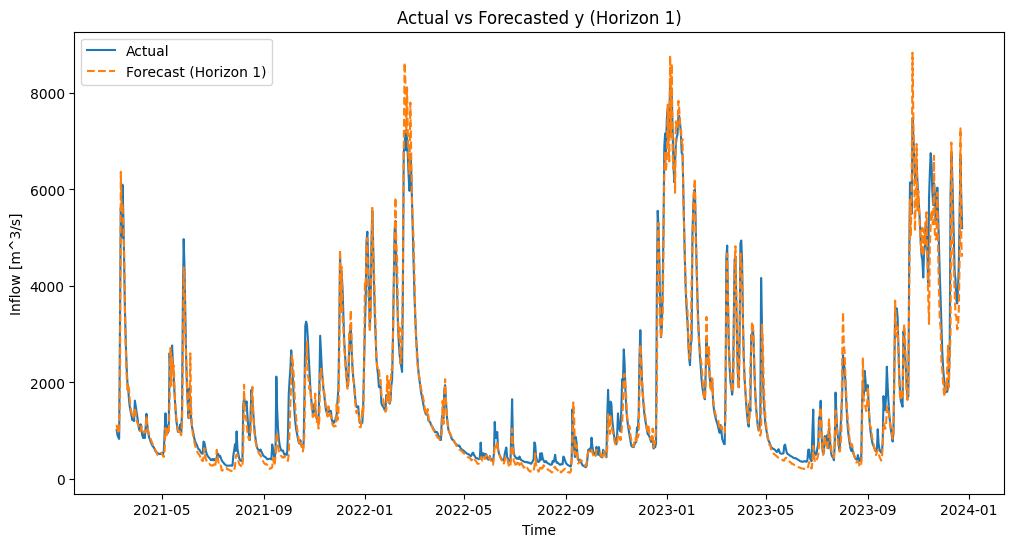

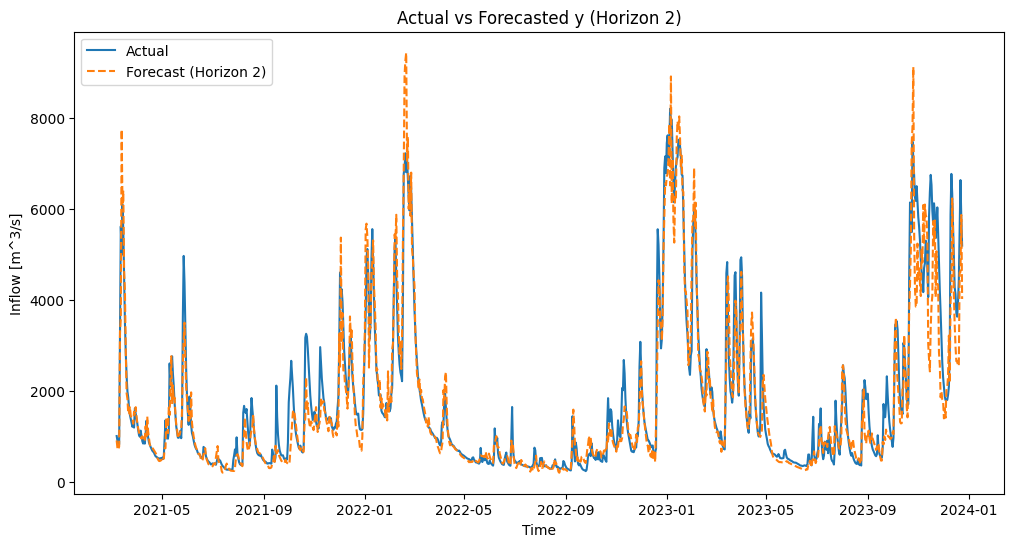

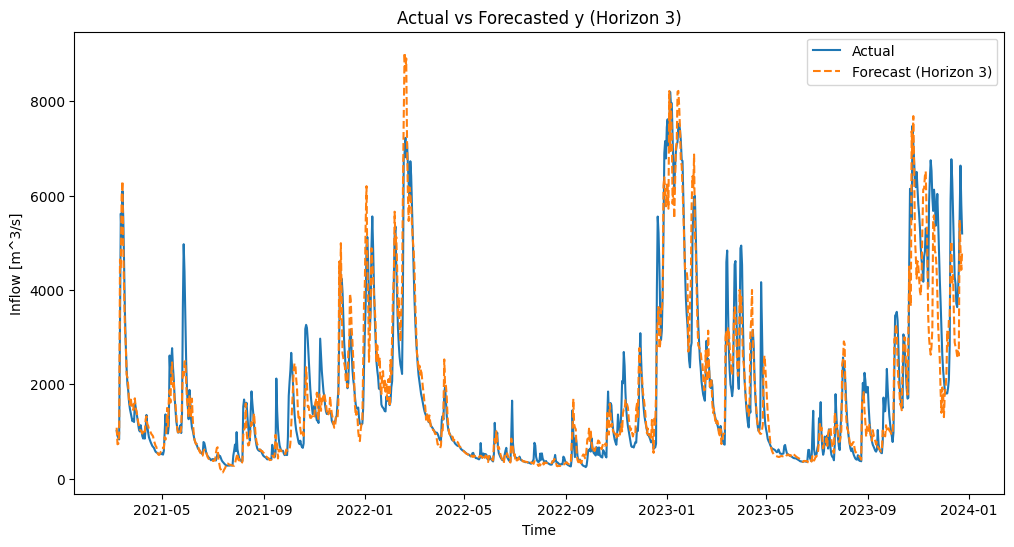

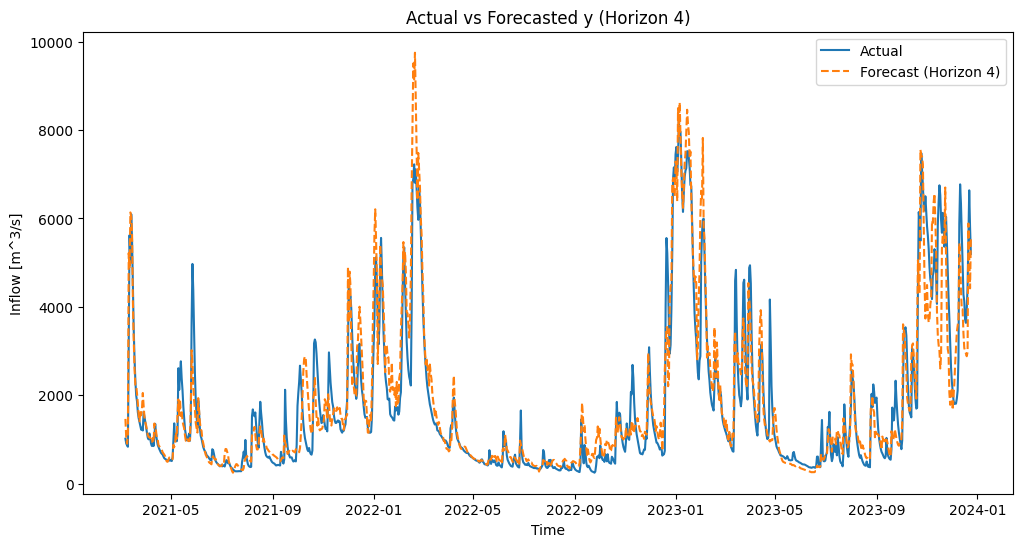

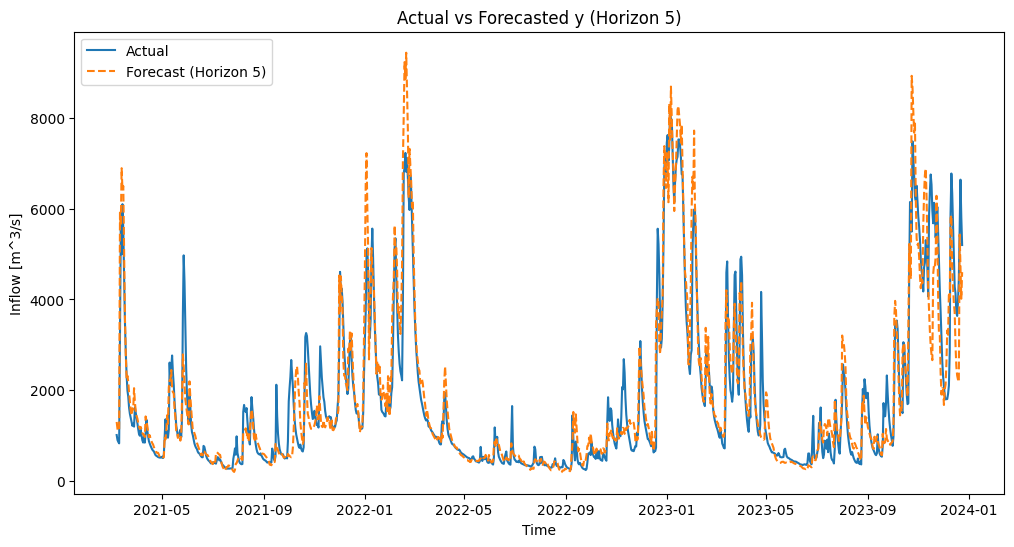

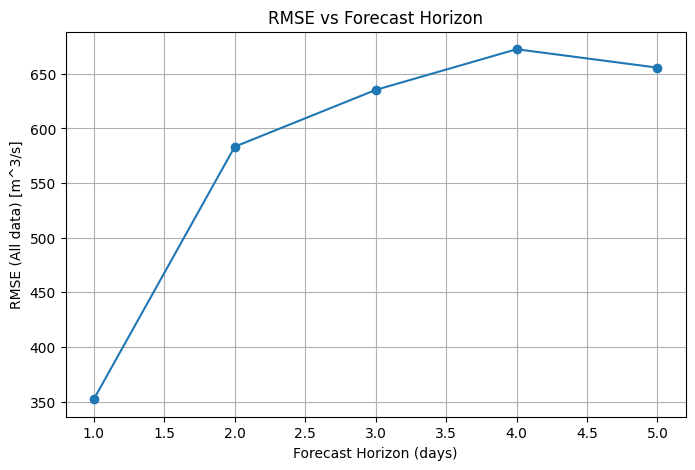

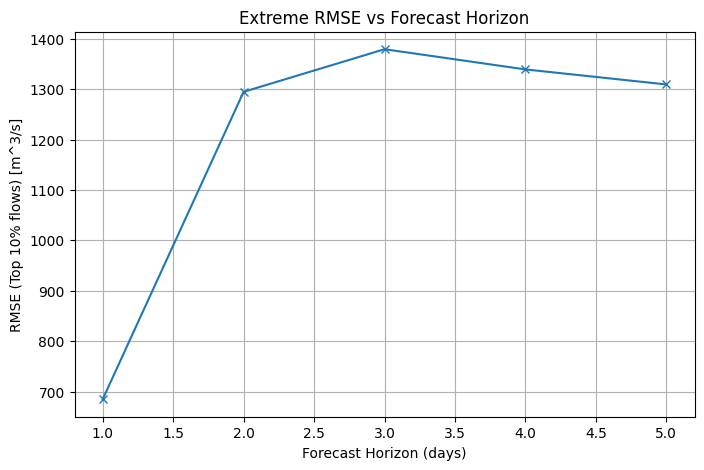

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

##########################################
# Data Loading and Preprocessing
##########################################

# Load data
D = pd.read_csv("/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv")
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']
D_time_indexed = D.set_index('t').sort_index()

# Correct extreme values
D_time_indexed.loc[D_time_indexed['temp_mean_daily'] > 35, 'temp_mean_daily'] = D_time_indexed['temp_mean_daily'].shift(1)
D_time_indexed.loc[D_time_indexed['precip_total_daily'] > 100, 'precip_total_daily'] = 0

# Create features
D_time_indexed['temp_forecast'] = D_time_indexed['temp_mean_daily']
D_time_indexed['precip_forecast'] = D_time_indexed['precip_total_daily'].ewm(alpha=0.1, adjust=False).mean()
D_time_indexed['Year_sin'] = np.sin(2 * np.pi * D_time_indexed.index.dayofyear / 365)
D_time_indexed['Year_cos'] = np.cos(2 * np.pi * D_time_indexed.index.dayofyear / 365)

# Create snow indicator (temp < 0 and rain > 0)
D_time_indexed['snow'] = ((D_time_indexed['temp_mean_daily'] < 0) & (D_time_indexed['precip_total_daily'] > 0)).astype(int)

# Select columns to standardize
feature_cols = ['y', 'temp_mean_daily', 'precip_total_daily', 'temp_forecast', 'precip_forecast']

# Standardize
means = D_time_indexed[feature_cols].mean()
stds = D_time_indexed[feature_cols].std()

D_time_indexed[feature_cols] = (D_time_indexed[feature_cols] - means) / stds

# For inverse transformation later
def inverse_transform(y_scaled, feature_name):
    return y_scaled * stds[feature_name] + means[feature_name]

# Define scoring period
score_period = D_time_indexed.index[-1023:]
score_start = score_period[0]

##########################################
# Helper Functions
##########################################

def create_offline_dataset_horizon(df, window_size, k):
    X_hist_list, X_forecast_list, y_list, indices = [], [], [], []
    for i in range(window_size, len(df) - (k - 1)):
        target_date = df.index[i + (k - 1)]
        hist = df.iloc[i - window_size:i][['y', 'temp_mean_daily', 'precip_total_daily', 'snow']].values.astype(np.float32)
        fcst = np.array([
            df.iloc[i + (k - 1)]['temp_forecast'],
            df.iloc[i + (k - 1)]['precip_forecast'],
            np.sin(2 * np.pi * target_date.dayofyear / 365),
            np.cos(2 * np.pi * target_date.dayofyear / 365)
        ], dtype=np.float32)
        label = float(df.iloc[i + (k - 1)]['y'])
        X_hist_list.append(hist)
        X_forecast_list.append(fcst)
        y_list.append(label)
        indices.append(target_date)
    return np.array(X_hist_list), np.array(X_forecast_list), np.array(y_list), np.array(indices)


def build_offline_model(window_size, loss_fn):
    hist_input = Input(shape=(window_size, 4))  # now 4 inputs per timestep (y, temp, precip, snow)
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    
    fcst_input = Input(shape=(4,))
    y = Dense(32, activation='relu')(fcst_input)
    y = Dense(32, activation='relu')(y)

    combined = Concatenate()([x, y])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)

    model = Model(inputs=[hist_input, fcst_input], outputs=output)
    model.compile(optimizer=Adam(0.001), loss=loss_fn)
    return model


def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.nanmean((y_true - y_pred)**2))


def calculate_rmse_extreme(y_true, y_pred, percentile=90):
    threshold = np.percentile(y_true, percentile)
    mask = y_true >= threshold
    return np.sqrt(np.nanmean((y_true[mask] - y_pred[mask])**2))


##########################################
# Training and Evaluation
##########################################

# Define simple loss function (mse)
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

window_size = 10
horizons = [1, 2, 3, 4, 5]

results = {}

for k in horizons:
    print(f"Training model for Horizon {k}")

    X_hist, X_fcst, y, indices = create_offline_dataset_horizon(D_time_indexed, window_size, k)
    train_mask = indices < score_start
    test_mask = indices >= score_start

    X_hist_train, X_fcst_train, y_train = X_hist[train_mask], X_fcst[train_mask], y[train_mask]
    X_hist_test, X_fcst_test, y_test, indices_test = X_hist[test_mask], X_fcst[test_mask], y[test_mask], indices[test_mask]

    model = build_offline_model(window_size, loss_fn=mse_loss)

    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

    model.fit([X_hist_train, X_fcst_train], y_train,
              validation_split=0.2,
              epochs=200,
              batch_size=16,
              verbose=0,
              callbacks=callbacks)

    # Predict
    y_pred_scaled = model.predict([X_hist_test, X_fcst_test], verbose=0).flatten()

    # Inverse-transform back to real values
    y_pred_real = inverse_transform(y_pred_scaled, 'y')
    y_test_real = inverse_transform(y_test, 'y')

    rmse_all = calculate_rmse(y_test_real, y_pred_real)
    rmse_extreme = calculate_rmse_extreme(y_test_real, y_pred_real)

    print(f"Horizon {k}: RMSE (All) = {rmse_all:.4f}, RMSE (Extreme) = {rmse_extreme:.4f}")

    results[k] = {
        'indices': indices_test,
        'y_true_real': y_test_real,
        'y_pred_real': y_pred_real,
        'rmse_all': rmse_all,
        'rmse_extreme': rmse_extreme
    }

##########################################
# Plotting Results
##########################################

for k in horizons:
    res = results[k]
    plt.figure(figsize=(12,6))
    plt.plot(res['indices'], res['y_true_real'], label='Actual')
    plt.plot(res['indices'], res['y_pred_real'], label=f'Forecast (Horizon {k})', linestyle='--')
    plt.title(f'Actual vs Forecasted y (Horizon {k})')
    plt.xlabel('Time')
    plt.ylabel('Inflow [m^3/s]')
    plt.legend()
    plt.show()

# RMSE vs Horizon plot
plt.figure(figsize=(8,5))
rmses = [results[k]['rmse_all'] for k in horizons]
plt.plot(horizons, rmses, marker='o')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('RMSE (All data) [m^3/s]')
plt.title('RMSE vs Forecast Horizon')
plt.grid(True)
plt.show()

# RMSE Extreme plot
plt.figure(figsize=(8,5))
rmses_extreme = [results[k]['rmse_extreme'] for k in horizons]
plt.plot(horizons, rmses_extreme, marker='x')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('RMSE (Top 10% flows) [m^3/s]')
plt.title('Extreme RMSE vs Forecast Horizon')
plt.grid(True)
plt.show()


===== Training NORMAL_MSE Model =====
Training model for Horizon 1
Horizon 1: RMSE (All) = 335.7985, RMSE (Extreme) = 736.4036
Training model for Horizon 2
Horizon 2: RMSE (All) = 581.4127, RMSE (Extreme) = 1277.6186
Training model for Horizon 3
Horizon 3: RMSE (All) = 721.7048, RMSE (Extreme) = 1752.8983
Training model for Horizon 4
Horizon 4: RMSE (All) = 769.0452, RMSE (Extreme) = 1834.0280
Training model for Horizon 5
Horizon 5: RMSE (All) = 750.7468, RMSE (Extreme) = 1611.7686

===== Training EXTREME_ONLY Model =====
Training model for Horizon 1
Horizon 1: RMSE (All) = 471.0480, RMSE (Extreme) = 662.6815
Training model for Horizon 2
Horizon 2: RMSE (All) = 968.7133, RMSE (Extreme) = 1202.0710
Training model for Horizon 3
Horizon 3: RMSE (All) = 1242.4010, RMSE (Extreme) = 1366.5472
Training model for Horizon 4
Horizon 4: RMSE (All) = 1311.9917, RMSE (Extreme) = 1412.5406
Training model for Horizon 5
Horizon 5: RMSE (All) = 1220.8543, RMSE (Extreme) = 1786.2190


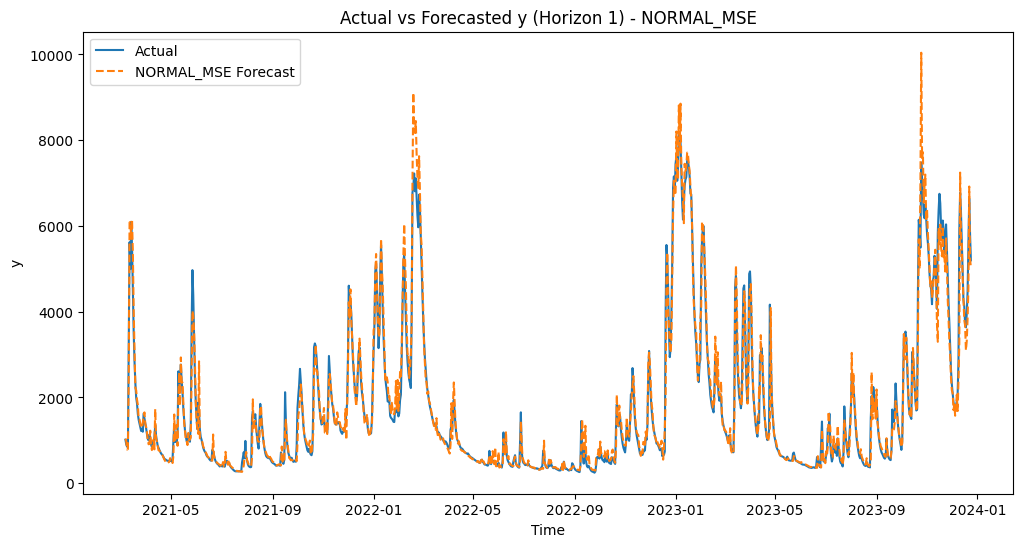

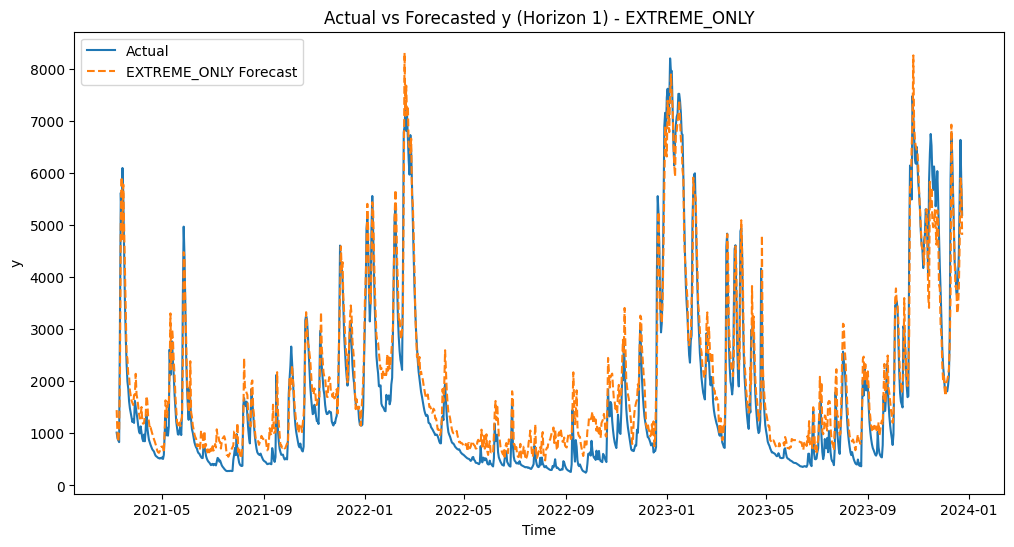

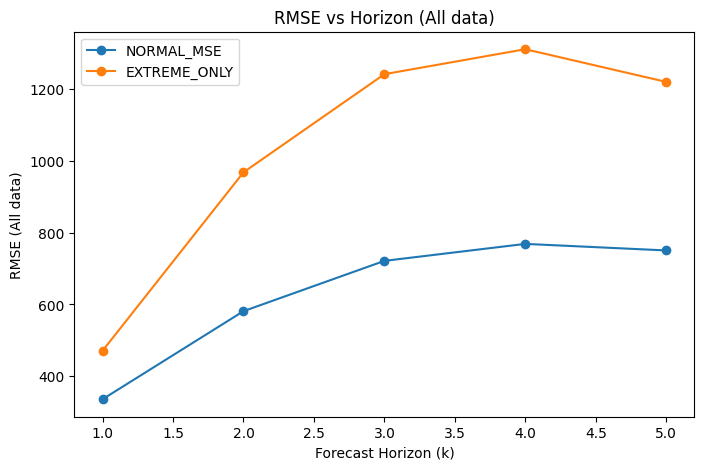

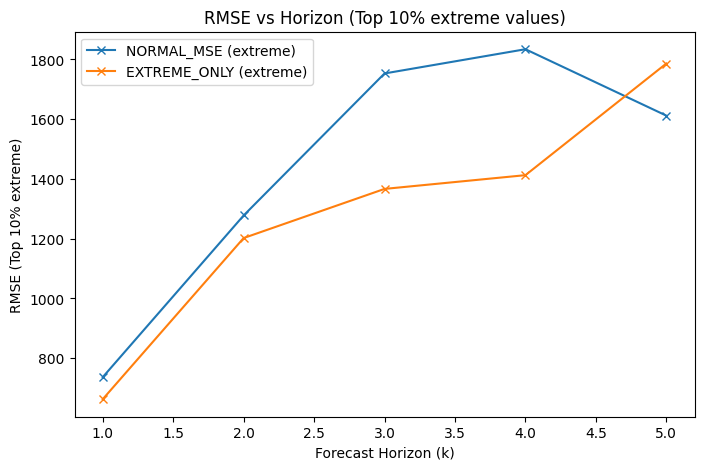

In [16]:
...

##########################################
# Training and Evaluation with Extreme Only Model
##########################################

window_size = 10
horizons = [1, 2, 3, 4, 5]

results = {}
models_to_train = ['normal_mse', 'extreme_only']

for model_type in models_to_train:
    print(f"\n===== Training {model_type.upper()} Model =====")

    rmse_all = {}
    rmse_extreme = {}
    forecasts = {}

    for k in horizons:
        print(f"Training model for Horizon {k}")

        X_hist, X_fcst, y, indices = create_offline_dataset_horizon(D_time_indexed, window_size, k)
        train_mask = indices < score_start
        test_mask = indices >= score_start

        X_hist_train, X_fcst_train, y_train = X_hist[train_mask], X_fcst[train_mask], y[train_mask]
        X_hist_test, X_fcst_test, y_test, indices_test = X_hist[test_mask], X_fcst[test_mask], y[test_mask], indices[test_mask]

        if model_type == 'extreme_only':
            threshold = np.percentile(y_train, 70)
            extreme_mask = y_train >= threshold
            X_hist_train = X_hist_train[extreme_mask]
            X_fcst_train = X_fcst_train[extreme_mask]
            y_train = y_train[extreme_mask]

        if len(y_test) == 0 or len(y_train) == 0:
            continue

        model = build_offline_model(window_size, loss_fn=mse_loss)

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ]

        model.fit([X_hist_train, X_fcst_train], y_train,
                  validation_split=0.2,
                  epochs=100,
                  batch_size=32,
                  verbose=0,
                  callbacks=callbacks)

        y_pred = model.predict([X_hist_test, X_fcst_test], verbose=0).flatten()

        forecasts[k] = (indices_test, y_test, y_pred)
        rmse_all[k] = calculate_rmse(y_test, y_pred)
        rmse_extreme[k] = calculate_rmse_extreme(y_test, y_pred)

        print(f"Horizon {k}: RMSE (All) = {rmse_all[k]:.4f}, RMSE (Extreme) = {rmse_extreme[k]:.4f}")

    results[model_type] = {'forecasts': forecasts, 'rmse_all': rmse_all, 'rmse_extreme': rmse_extreme}

##########################################
# Plotting Comparison
##########################################

for model_type in models_to_train:
    idx, y_true, y_pred = results[model_type]['forecasts'][1]
    plt.figure(figsize=(12,6))
    plt.plot(idx, y_true, label='Actual')
    plt.plot(idx, y_pred, label=f'{model_type.upper()} Forecast', linestyle='--')
    plt.title(f'Actual vs Forecasted y (Horizon 1) - {model_type.upper()}')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plt.figure(figsize=(8,5))
for model_type in models_to_train:
    rmse_values = [results[model_type]['rmse_all'][k] for k in horizons]
    plt.plot(horizons, rmse_values, marker='o', label=f'{model_type.upper()}')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (All data)')
plt.title('RMSE vs Horizon (All data)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for model_type in models_to_train:
    rmse_values_extreme = [results[model_type]['rmse_extreme'][k] for k in horizons]
    plt.plot(horizons, rmse_values_extreme, marker='x', label=f'{model_type.upper()} (extreme)')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (Top 10% extreme)')
plt.title('RMSE vs Horizon (Top 10% extreme values)')
plt.legend()
plt.show()


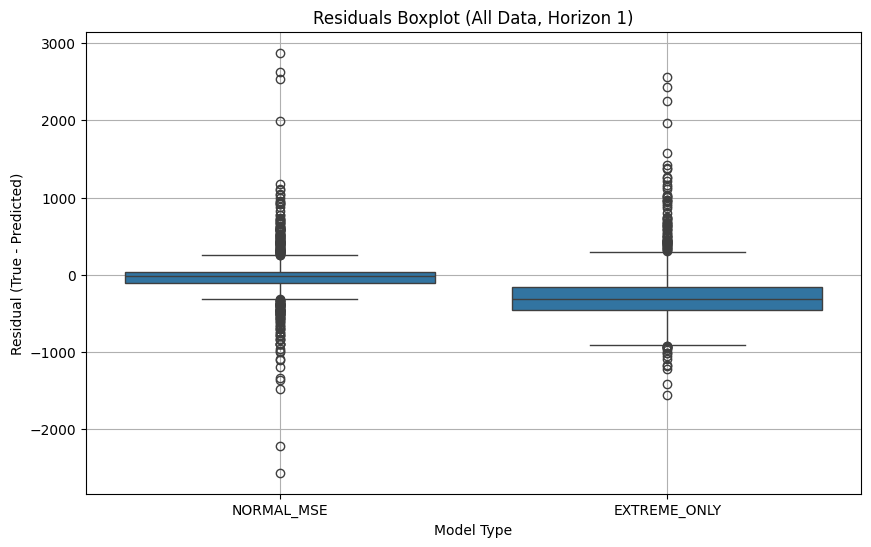

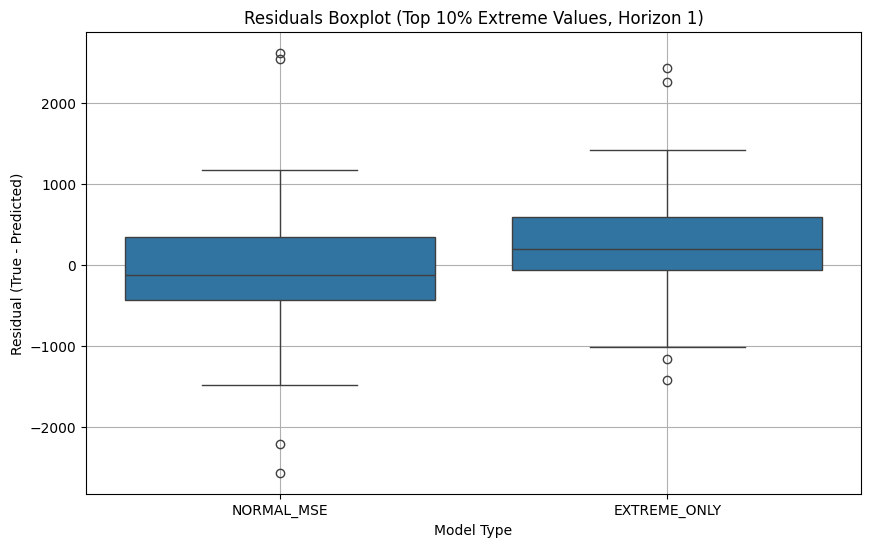

In [19]:
...

##########################################
# Residuals Boxplot (All Data)
##########################################

import seaborn as sns

residuals = []
labels = []

for model_type in models_to_train:
    _, y_true, y_pred = results[model_type]['forecasts'][1]
    residual = y_true - y_pred
    residuals.append(residual)
    labels.extend([model_type.upper()] * len(residual))

residuals = np.concatenate(residuals)

plt.figure(figsize=(10,6))
sns.boxplot(x=labels, y=residuals)
plt.title('Residuals Boxplot (All Data, Horizon 1)')
plt.ylabel('Residual (True - Predicted)')
plt.xlabel('Model Type')
plt.grid(True)
plt.show()

##########################################
# Residuals Boxplot (Extreme Data Only)
##########################################

residuals_extreme = []
labels_extreme = []

for model_type in models_to_train:
    _, y_true, y_pred = results[model_type]['forecasts'][1]
    threshold = np.percentile(y_true, 90)
    extreme_mask = y_true >= threshold
    residual_extreme = (y_true - y_pred)[extreme_mask]
    residuals_extreme.append(residual_extreme)
    labels_extreme.extend([model_type.upper()] * len(residual_extreme))

residuals_extreme = np.concatenate(residuals_extreme)

plt.figure(figsize=(10,6))
sns.boxplot(x=labels_extreme, y=residuals_extreme)
plt.title('Residuals Boxplot (Top 10% Extreme Values, Horizon 1)')
plt.ylabel('Residual (True - Predicted)')
plt.xlabel('Model Type')
plt.grid(True)
plt.show()

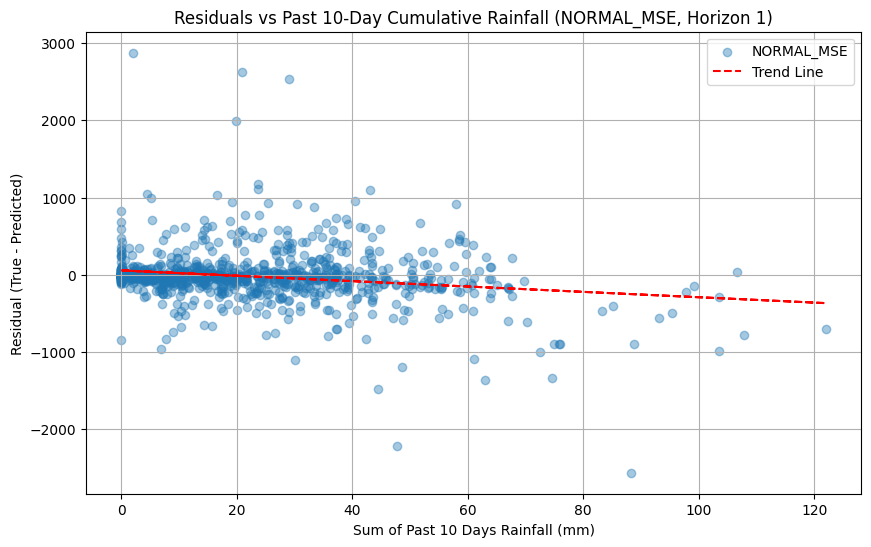

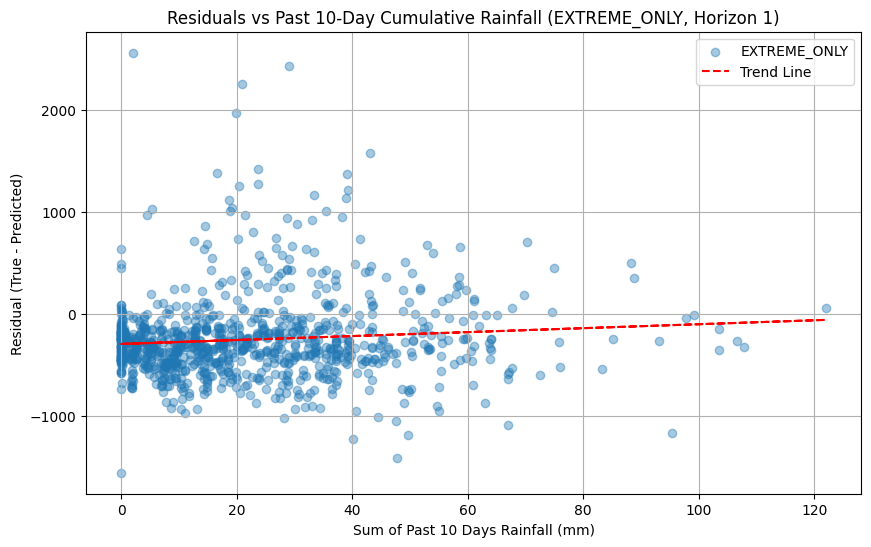

In [22]:
##########################################
# Residuals vs Past 10-Day Cumulative Rainfall (All Data)
##########################################

from scipy.stats import linregress

for model_type in models_to_train:
    idx, y_true, y_pred = results[model_type]['forecasts'][1]
    X_hist, X_fcst, y, indices = create_offline_dataset_horizon(D_time_indexed, window_size, 1)
    test_mask = indices >= score_start

    X_hist_test = X_hist[test_mask]
    cum_rain_last_10_days = np.sum(X_hist_test[:, :, 2], axis=1)  # Sum of past 10 days precipitation

    residual = y_true - y_pred

    slope, intercept, _, _, _ = linregress(cum_rain_last_10_days, residual)
    line = slope * cum_rain_last_10_days + intercept

    plt.figure(figsize=(10,6))
    plt.scatter(cum_rain_last_10_days, residual, alpha=0.4, label=f'{model_type.upper()}')
    plt.plot(cum_rain_last_10_days, line, color='red', linestyle='--', label='Trend Line')
    plt.title(f'Residuals vs Past 10-Day Cumulative Rainfall ({model_type.upper()}, Horizon 1)')
    plt.xlabel('Sum of Past 10 Days Rainfall (mm)')
    plt.ylabel('Residual (True - Predicted)')
    plt.grid(True)
    plt.legend()
    plt.show()
